Dataset

In [1]:
from ColorNeuralNet import *

DATASETFOLDER = './Datasets/'
TRAININGDATASETHLS = f"{DATASETFOLDER}TrainingDatasetHLS.txt"
TESTDATASETHLS = f"{DATASETFOLDER}TestDatasetHLS.txt"
batch_size = 4


train_loader = dataloaderSetup(TRAININGDATASETHLS, 1)
test_loader = dataloaderSetup(TESTDATASETHLS, 1)



Example for hsl and label size

The hsl size only contains the H and L Values, because of that the size is only 2.

In [2]:
hsl, label = next(iter(train_loader))
print(f"batch shape of hsl values: {hsl.size()}")
print(f"batch shape of labels: {label.size()}")

batch shape of hsl values: torch.Size([4, 2])
batch shape of labels: torch.Size([4, 1])


Examples for 4 batches from the training datasetloader



In [3]:
print("hsl: ([H,L])                 ; label:([class_id]); label as class: class_name")

for i, (hsl, labels) in enumerate(train_loader):
    if(i == 4):
        break
    for j, (not_used) in enumerate(hsl):
        print(f"hsl:{hsl[j]} ; label:{labels[j]}; label as class: {all_classes[convertFloatTensorToLongTensor(labels[j])]}")

hsl: ([H,L])                 ; label:([class_id]); label as class: class_name
hsl:tensor([0.8798, 0.3431]) ; label:tensor([1.]); label as class: red
hsl:tensor([0.6518, 0.3255]) ; label:tensor([3.]); label as class: other
hsl:tensor([0.4311, 0.4216]) ; label:tensor([2.]); label as class: green
hsl:tensor([0.3580, 0.9314]) ; label:tensor([0.]); label as class: white
hsl:tensor([0.3114, 0.2647]) ; label:tensor([2.]); label as class: green
hsl:tensor([0.1897, 0.3824]) ; label:tensor([2.]); label as class: green
hsl:tensor([0.4695, 0.1471]) ; label:tensor([2.]); label as class: green
hsl:tensor([0.9526, 0.5137]) ; label:tensor([1.]); label as class: red
hsl:tensor([0.8395, 0.5471]) ; label:tensor([3.]); label as class: other
hsl:tensor([0.3981, 0.3608]) ; label:tensor([2.]); label as class: green
hsl:tensor([0.8869, 0.5333]) ; label:tensor([3.]); label as class: other
hsl:tensor([0.8167, 0.8902]) ; label:tensor([0.]); label as class: white
hsl:tensor([0.3980, 0.4686]) ; label:tensor([2.]);

In [4]:
device = "cpu"
model = NeuralNet(input_size, hidden_size, num_classes).to(device)
print(model)

NeuralNet(
  (l1): Linear(in_features=2, out_features=25, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=25, out_features=4, bias=True)
)


Confusion matrix examples from training

Epoch [1/3], Step [40/400], Accuracy: 0.3000, Loss: 1.2553                                                  

Epoch [1/3], Step [80/400], Accuracy: 0.2125, Loss: 1.3641                                                  

Epoch [1/3], Step [120/400], Accuracy: 0.2812, Loss: 1.3242                                                  

Epoch [1/3], Step [160/400], Accuracy: 0.3375, Loss: 1.3159                                                  

Epoch [1/3], Step [200/400], Accuracy: 0.4062, Loss: 1.2975                                                  

Epoch [1/3], Step [240/400], Accuracy: 0.5250, Loss: 1.1973                                                  

Epoch [1/3], Step [280/400], Accuracy: 0.5000, Loss: 1.1849                                                  

Epoch [1/3], Step [320/400], Accuracy: 0.5687, Loss: 1.0416                                                  

Epoch [1/3], Step [360/400], Accuracy: 0.5437, Loss: 1.3218                                                  

Epo

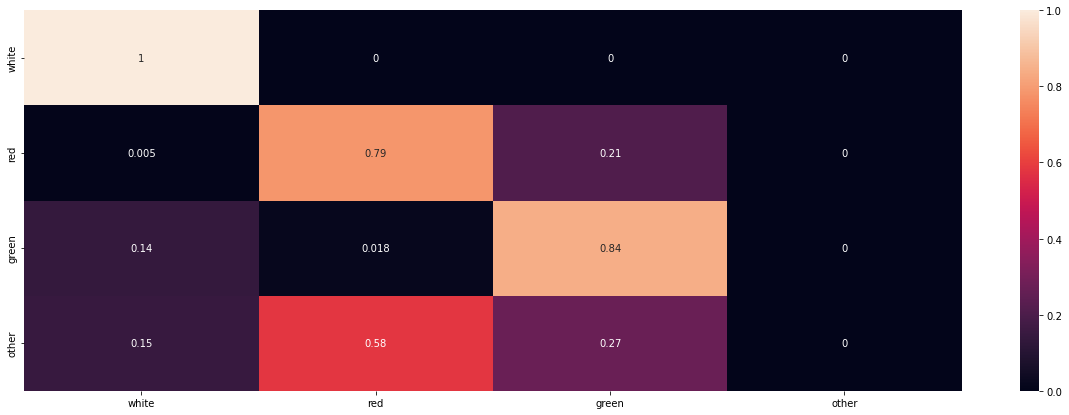


####################################Training Resumed#######################################

Epoch [2/3], Step [40/400], Accuracy: 0.6625, Loss: 1.2449                                                  

Epoch [2/3], Step [80/400], Accuracy: 0.6625, Loss: 0.7543                                                  

Epoch [2/3], Step [120/400], Accuracy: 0.5687, Loss: 1.2909                                                  

Epoch [2/3], Step [160/400], Accuracy: 0.6937, Loss: 1.1379                                                  

Epoch [2/3], Step [200/400], Accuracy: 0.7250, Loss: 0.9310                                                  

Epoch [2/3], Step [240/400], Accuracy: 0.6438, Loss: 1.0747                                                  

Epoch [2/3], Step [280/400], Accuracy: 0.6625, Loss: 1.0255                                                  

Epoch [2/3], Step [320/400], Accuracy: 0.6562, Loss: 1.2115                                                  

Epoch [2/3], Step [3

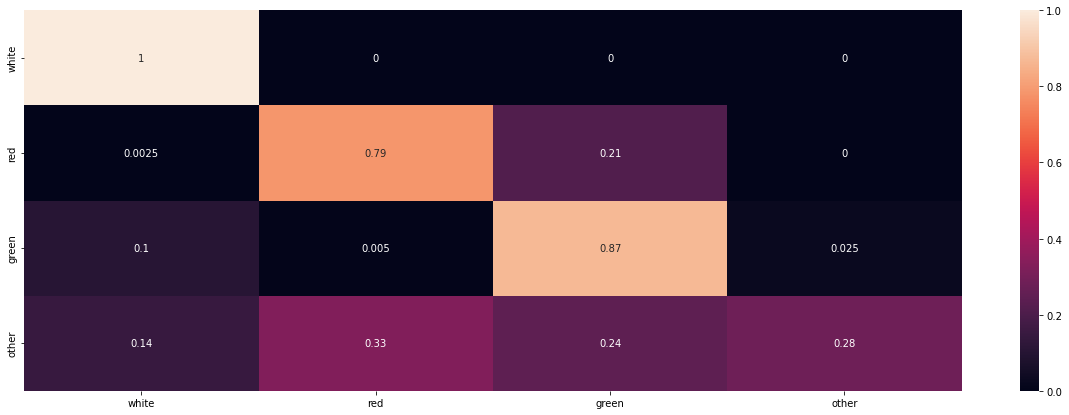


####################################Training Resumed#######################################

Epoch [3/3], Step [40/400], Accuracy: 0.8000, Loss: 1.2308                                                  

Epoch [3/3], Step [80/400], Accuracy: 0.6562, Loss: 0.9912                                                  

Epoch [3/3], Step [120/400], Accuracy: 0.7125, Loss: 0.8797                                                  

Epoch [3/3], Step [160/400], Accuracy: 0.7000, Loss: 0.8169                                                  

Epoch [3/3], Step [200/400], Accuracy: 0.7000, Loss: 0.8912                                                  

Epoch [3/3], Step [240/400], Accuracy: 0.7438, Loss: 0.6039                                                  

Epoch [3/3], Step [280/400], Accuracy: 0.6438, Loss: 1.2821                                                  

Epoch [3/3], Step [320/400], Accuracy: 0.6750, Loss: 0.7057                                                  

Epoch [3/3], Step [3

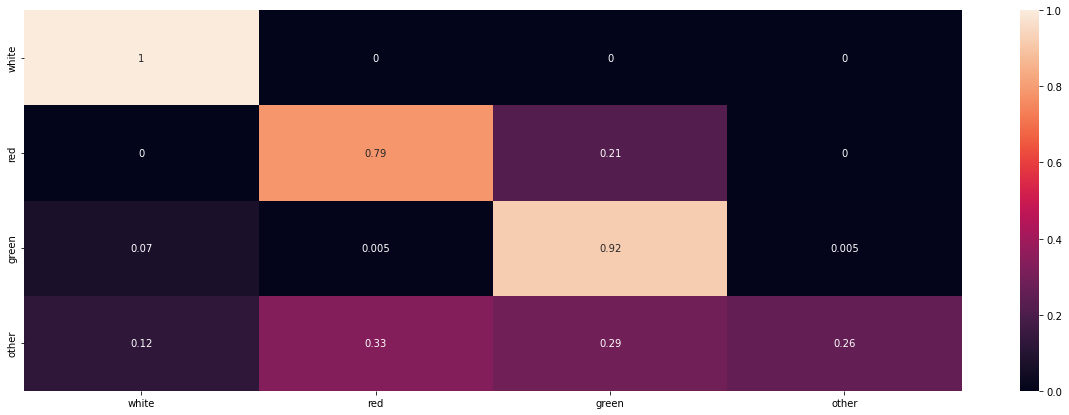

In [5]:
num_epochs = 3

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model = trainingPhase(model, criterion, optimizer, train_loader, num_epochs, 0.1, 0, device, confusionmatrixdevice, writer, FILE, all_classes, 0)


Confusion matrix examples from testing



Starting with Testing!

Creating Confusion Matrix ...
[███████████████████████████████████████████████████████████-] 99.0% ...remaining Time: 0.0s


###########################Examples for wrong predictions##################################

predicted: tensor([2, 2, 1, 1])
labels: tensor([3, 2, 3, 1])
Wrong

predicted: tensor([2, 2, 1, 1])
labels: tensor([3, 2, 3, 1])
Wrong

predicted: tensor([1, 2, 2, 0])
labels: tensor([3, 3, 1, 3])
Wrong

predicted: tensor([1, 2, 2, 0])
labels: tensor([3, 3, 1, 3])
Wrong

predicted: tensor([1, 2, 2, 0])
labels: tensor([3, 3, 1, 3])
Wrong

predicted: tensor([1, 2, 2, 0])
labels: tensor([3, 3, 1, 3])
Wrong

predicted: tensor([2, 0, 3, 0])
labels: tensor([1, 3, 3, 3])
Wrong

predicted: tensor([2, 0, 3, 0])
labels: tensor([1, 3, 3, 3])
Wrong

predicted: tensor([2, 0, 3, 0])
labels: tensor([1, 3, 3, 3])
Wrong

predicted: tensor([0, 1, 0, 0])
labels: tensor([0, 3, 0, 3])
Wrong

predicted: tensor([0, 1, 0, 0])
labels: tensor([0, 3, 0, 3])
Wrong

predicte

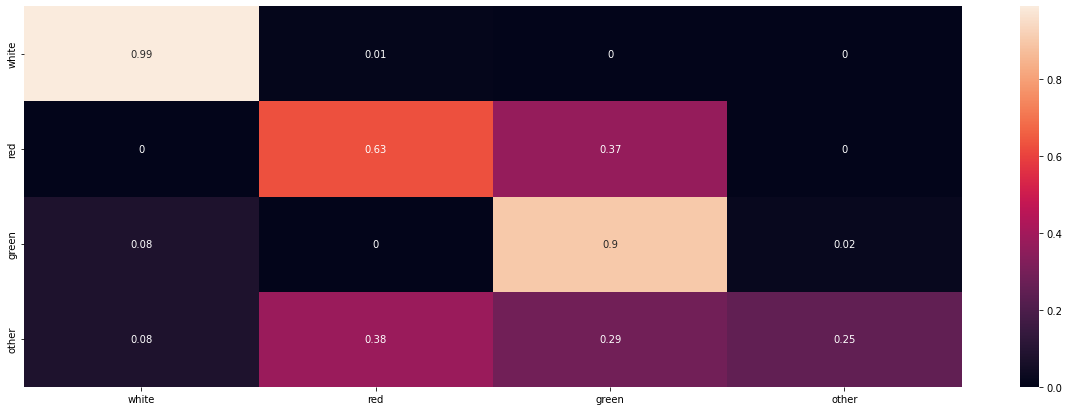

In [6]:
testingPhase(model, test_loader, writer, FILE, all_classes, 0, confusionmatrixdevice)